# King et al 2020 Exploratory Data Analysis

**Authorship:**<br>
Created by: Adam Klie, *11/18/2022*<br>
Last updated: Adam Klie, *02/04/2023*
***
**Description:**
Notebook to explore the CRE MPRA dataset from King et al 2020. More info can be found here: https://www.notion.so/adamklie/king20-01bc9b4d143944e49a238d8eb1d84a8d
***

In [54]:
import os
import numpy as np
import pandas as pd

# Load data

In [23]:
dataset_dir = "/cellar/users/aklie/data/eugene/"

In [24]:
design_file = os.path.join(dataset_dir, "king20", "design.xlsx")

In [25]:
genomic_design_df = pd.read_excel(design_file, sheet_name=6)

# Check how many sequences and barcodes we have
Note we have 8 barcodes per sequence, so we need to collapse based on sequence.

In [34]:
# How many Basal barcodes are there
len(genomic_design_df[genomic_design_df["Element_id"] == "Basal"])

112

In [35]:
# How many total barcodes?
len(genomic_design_df[genomic_design_df["Element_id"].str.contains("Genomic")])

3224

In [36]:
# I seem to be missing 4
(3256 - 3224)/8

4.0

In [37]:
# Have all the mutated
len(genomic_design_df[genomic_design_df["Element_id"].str.contains("All_Mutated")])

3256

In [38]:
# How many none "SYN" sequences do we have?
len(genomic_design_df[genomic_design_df["Element_id"].str.contains("Scalar")].groupby("Sequence").count())

12

In [39]:
# Do we have any sequences with more or less than 8 barcodes?
(genomic_design_df.groupby("Sequence").count()["BC"] != 8).sum()

0

In [40]:
# Basal should
(genomic_design_df.groupby("Element_id").count()["BC"] != 8).sum()

1

In [41]:
# Make sure all the Sequences that are the same have the same Element_id
(genomic_design_df.groupby("Sequence").agg(lambda x: len(set(x)))["Element_id"] != 1).sum()

0

In [42]:
# Collapse based on Sequence column
genomic_design_df = genomic_design_df.drop_duplicates(subset="Sequence")
len(genomic_design_df)

823

In [45]:
# Keep only the Genomic and All_Mutated sequences
genomic_design_df = genomic_design_df[~genomic_design_df["Element_id"].str.contains("Scalar")]
genomic_design_df = genomic_design_df[~genomic_design_df["Element_id"].str.contains("Basal")]

In [46]:
# How many are left
len(genomic_design_df)

810

In [49]:
# Here are those 4
genomic_design_df["range"].drop_duplicates(keep=False)
genomic_design_df["range"] = genomic_design_df["Element_id"].str.replace("_Genomic", "").str.replace("_All_Mutated", "")
genomic_design_df[genomic_design_df["Element_id"].str.contains("Genomic")]

In [56]:
sequences = genomic_design_df["Sequence"].values

# SeqData analysis

In [57]:
import seqdata as sd
from seqdata._preprocess.basic import reverse_complement_seq

In [58]:
# Create a SeqData object
sdata = sd.SeqData(
    seqs=sequences,
    names=genomic_design_df["Element_id"].values,
    seqs_annot=genomic_design_df.drop("Sequence", axis=1).set_index("Element_id"),
)
sdata

SeqData object with = 810 seqs
seqs = (810,)
names = (810,)
rev_seqs = None
ohe_seqs = None
ohe_rev_seqs = None
seqs_annot: 'BC', 'range'
pos_annot: None
seqsm: None
uns: None

In [60]:
# Simple function to incorporate into SeqData for measuring seq lens
def seq_len(seq, ohe=False):
    if ohe:
        return seq.shape[1]
    else:
        return len(seq)

def seq_lens(seqs, ohe=False):
    if ohe:
        return np.array([seq.shape[1] for seq in seqs])
    else:
        return np.array([len(seq) for seq in seqs])

def seq_len_sdata(sdata, copy=False):
    if sdata.seqs is not None:
        sdata["seq_len"] = seq_lens(sdata.seqs, ohe=False)
    elif sdata.ohe_seqs is not None:
        sdata["seq_len"] = seq_lens(sdata.ohe_seqs, ohe=True)
    else:
        raise ValueError("No sequences found in sdata")

In [61]:
# Make sure Basal didn't sneak in
sdata.seqs[np.where(sdata.names=="Basal")[0]]

array([], dtype=object)

In [62]:
# Calculate seq lens
seq_len_sdata(sdata)
sdata["seq_len"].value_counts()

81    434
82    376
Name: seq_len, dtype: int64

In [68]:
# Building block - replace all X with .
building_block = "AGCTA(C|G)XXXXXXXXXXXXGT"
building_block = building_block.replace("X", ".")
building_block

'AGCTA(C|G)............GT'

In [69]:
# These are the motifs described in a previous publication from this group
sox2 = "GCTCATTGTTTC"
pou5f1 = "GGGATGCTAATC"
esrrb = "GTTCAAGGTCAC"
klf4 = "GGGGTGGGGCCG"
sox2_rev = reverse_complement_seq(sox2)
pou5f1_rev = reverse_complement_seq(pou5f1)
esrrb_rev = reverse_complement_seq(esrrb)
klf4_rev = reverse_complement_seq(klf4)

In [70]:
# Get a list of spans for all the building block instances in each sequence, some may overlap
import re
def get_spans(seq, pattern):
    return [m.span() for m in re.finditer(pattern, seq)]
building_block_spans = [get_spans(seq, building_block) for seq in sequences]

In [71]:
# Check the spans for the sequences for the building block
building_block_spans[0], len(building_block_spans)

([], 810)

In [72]:
# Get the spans for each consensus as defined above
sox2_spans = [get_spans(seq, sox2) for seq in sequences]
pou5f1_spans = [get_spans(seq, pou5f1) for seq in sequences]
esrrb_spans = [get_spans(seq, esrrb) for seq in sequences]
klf4_spans = [get_spans(seq, klf4) for seq in sequences]
sox2_rev_spans = [get_spans(seq, sox2_rev) for seq in sequences]
pou5f1_rev_spans = [get_spans(seq, pou5f1_rev) for seq in sequences]
esrrb_rev_spans = [get_spans(seq, esrrb_rev) for seq in sequences]
klf4_rev_spans = [get_spans(seq, klf4_rev) for seq in sequences]

In [73]:
# Add these to the dataframe
sdata.seqs_annot["sox2_spans"] = sox2_spans
sdata.seqs_annot["pouf51_spans"] = pou5f1_spans
sdata.seqs_annot["esrrb_spans"] = esrrb_spans
sdata.seqs_annot["klf4_spans"] = klf4_spans
sdata.seqs_annot["sox2_rev_spans"] = sox2_rev_spans
sdata.seqs_annot["pouf51_rev_spans"] = pou5f1_rev_spans
sdata.seqs_annot["esrrb_rev_spans"] = esrrb_rev_spans
sdata.seqs_annot["klf4_rev_spans"] = klf4_rev_spans

In [74]:
# Check for those that have a site 2, see if the element IDs match up with the spans for these Scalar seqs
sdata.seqs_annot

,BC,range,seq_len,sox2_spans,pouf51_spans,esrrb_spans,klf4_spans,sox2_rev_spans,pouf51_rev_spans,esrrb_rev_spans,klf4_rev_spans
Element_id,,,,,,,,,,,
chr6:72623138-72623219_Genomic,AAACAACGC,chr6:72623138-72623219,81,[],[],[],[],[],[],[],[]
chr16:87501907-87501988_Genomic,AAACAAGGT,chr16:87501907-87501988,81,[],[],[],[],[],[],[],[]
chr4:132315869-132315951_Genomic,AAACACAGC,chr4:132315869-132315951,82,[],[],[],[],[],[],[],[]
chr11:113197970-113198052_All_Mutated,AAACACCGA,chr11:113197970-113198052,82,[],[],[],[],[],[],[],[]
chr10:115312950-115313031_All_Mutated,AAACACTAC,chr10:115312950-115313031,81,[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...
chr14:59806818-59806899_Genomic,CTTGCAAGT,chr14:59806818-59806899,81,[],[],[],[],[],[],[],[]
chr15:82209826-82209907_Genomic,CTTGTTCAC,chr15:82209826-82209907,81,[],[],[],[],[],[],[],[]
chr13:40717504-40717586_Genomic,GAAAGCTGA,chr13:40717504-40717586,82,[],[],[],[],[],[],[],[]


# EUGENe analysis

In [1]:
import sys
sys.path.append("/cellar/users/aklie/projects/use_cases/king20/")
from utils import *
import eugene as eu

Global seed set to 13


In [7]:
dataset_dir = "/cellar/users/aklie/data/eugene/"

In [9]:
sdata = king20(dataset="GEN", dataset_dir=dataset_dir)

Design spreadsheet already exists at /cellar/users/aklie/data/eugene/king20/design.xlsx
Model spreadsheet already exists at /cellar/users/aklie/data/eugene/king20/models.xlsx
Gkmsvm fasta already exists at /cellar/users/aklie/data/eugene/king20/GEN.fasta


In [10]:
eu.pp.add_ranges_sdata(sdata)

SeqData object modified:
    seqs_annot:
        + chr, start, end


In [11]:
sdata.seqs_annot

,CRE_norm_expression_WT_all,chr,start,end
Element_id,,,,
chr10:108456620-108456701,2.292053,chr10,108456620,108456701
chr10:110940873-110940954,1.026702,chr10,110940873,110940954
chr10:115312950-115313031,1.818395,chr10,115312950,115313031
chr10:128631710-128631792,1.059821,chr10,128631710,128631792
chr10:18597642-18597724,0.827090,chr10,18597642,18597724
...,...,...,...,...
chr9:9961010-9961092,1.022724,chr9,9961010,9961092
chrX:114694676-114694758,1.952495,chrX,114694676,114694758
chrX:134296640-134296721,1.326962,chrX,134296640,134296721


## Data Visualization

In [12]:
# Add this to sanitize seqs
sdata = sdata[~np.array([seq is np.nan for seq in sdata.seqs])]

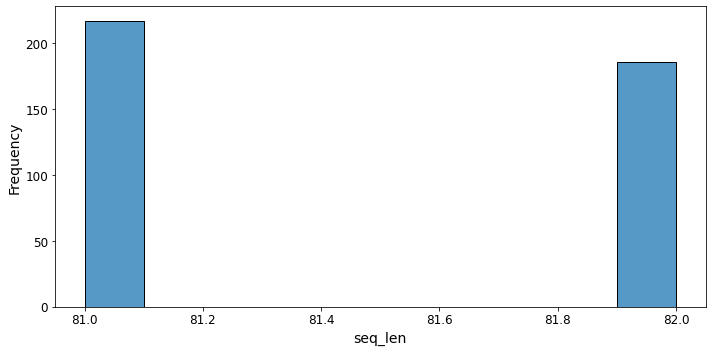

In [13]:
# Add this to some kind of preprocess seqs or seqs metrics
sdata["seq_len"] = [len(seq) for seq in sdata.seqs]
eu.pl.histplot(
    sdata, 
    keys="seq_len", 
    orient="h"
)

0


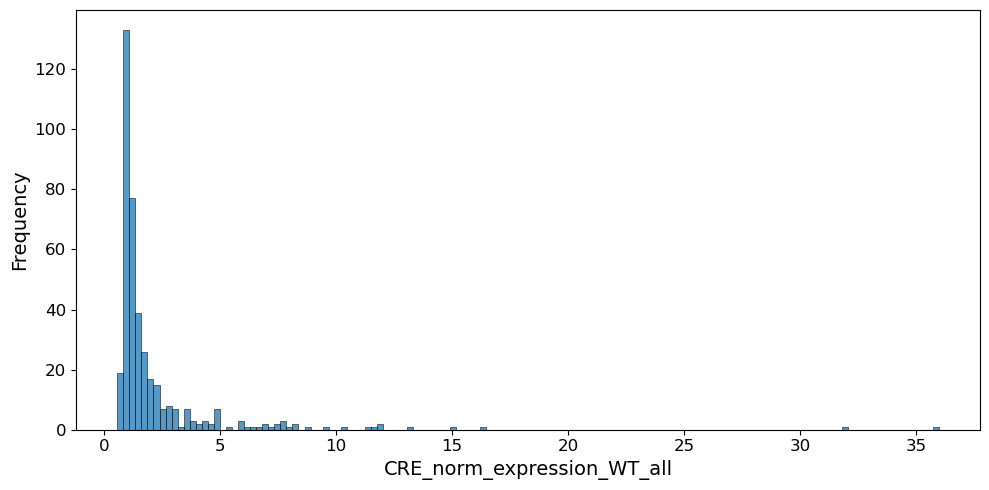

In [15]:
# Chceck the potential target to start
eu.pl.histplot(
    sdata,
    keys="CRE_norm_expression_WT_all",
    orient="h"
)
print(sdata["CRE_norm_expression_WT_all"].isna().sum())

## Preprocessing

In [16]:
# One-hot-encode, though this is no bueno
eu.pp.ohe_seqs_sdata(sdata, maxlen=sdata["seq_len"].max())

One-hot encoding sequences:   0%|          | 0/403 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 403 ohe_seqs added


In [19]:
# Add function registry for normalization
sdata["log_CRE_norm_expression_WT_all"] = np.log2(sdata["CRE_norm_expression_WT_all"])

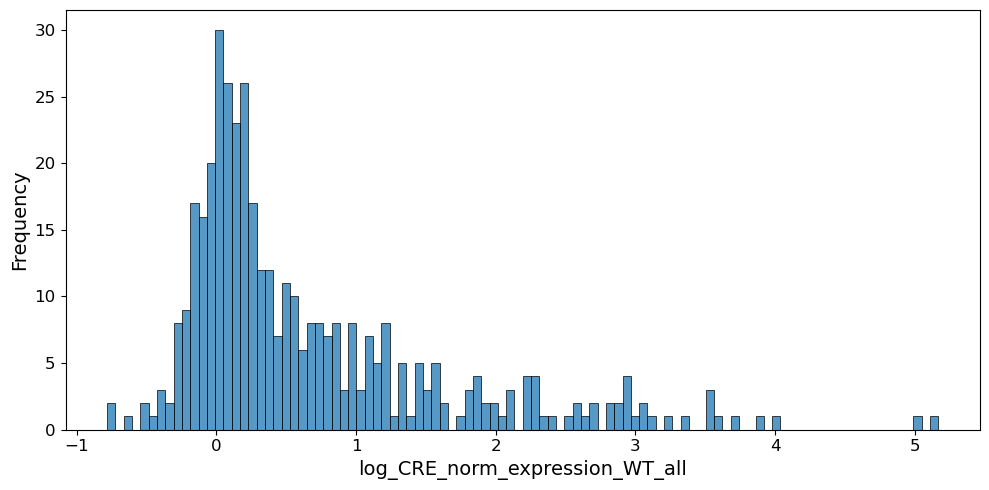

In [20]:
# Check log normalization
eu.pl.histplot(
    sdata,
    keys="log_CRE_norm_expression_WT_all",
    orient="h",
    bins=100
)

In [21]:
# Clean up features to use
sdata.seqs_annot = sdata.seqs_annot.replace({True: 1, False: 0})

In [22]:
eu.pp.train_test_split_sdata(sdata, split=0.5)

SeqData object modified:
    seqs_annot:
        + train_val


In [24]:
nan_mask = np.isnan(sdata["log_CRE_norm_expression_WT_all"])
sdata = sdata[~nan_mask]

In [25]:
sdata

SeqData object with = 403 seqs
seqs = (403,)
names = (403,)
rev_seqs = None
ohe_seqs = (403, 4, 82)
ohe_rev_seqs = None
seqs_annot: 'CRE_norm_expression_WT_all', 'chr', 'start', 'end', 'seq_len', 'log_CRE_norm_expression_WT_all', 'train_val'
pos_annot: None
seqsm: None
uns: None

# DONE!

---